# Semantic segmentation of polyps

In [1]:
import random
import os
import torch
import cv2
import segmentation_models_pytorch as smp
import numpy as np
from torch.utils.data import DataLoader
from segmentation_models_pytorch import utils
from modules.models import train
from modules.images import training_augmentation, validation_augmentation, preprocessing
from modules.datasets import CustomDataset
from modules.images import visualize
from modules.images import train_valid_test_split

d:\ProgramFiles\Anaconda\envs\polyps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we are going to separate our data into train, validation and test subdirectories. To avoid being biased towards some video sources douring training, we will shuffle the indices of the images.

In [2]:
NUMBER_OF_IMAGES = 612
train_ratio = 0.7

original_dir = './data/Original'
mask_dir = './data/Ground_Truth'
train_dir = './data/train'
valid_dir = './data/valid'
test_dir = './data/test'

train_valid_test_split(original_dir, mask_dir, train_dir, valid_dir, test_dir, NUMBER_OF_IMAGES, train_ratio)

Next we are going to initialize our model (in this case a UNet with a ResNet34 encoder pretrained on ImageNet) and all of our training parameters (more about the parameters can be found in the docstring of the train function).

In [3]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'



model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)



loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5)
]
goal_metric = 'iou_score'
goal_comparison = lambda x,y : x<y
verbose = True
n_epochs = 40
lr_schedule = [True, 20]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In this section we initialize the datasets and data loaders. 

In [4]:
x_train_dir = './data/train/Original/'
y_train_dir = './data/train/Ground_Truth/'
x_valid_dir = './data/valid/Original/'
y_valid_dir = './data/valid/Ground_Truth/'
x_test_dir = './data/test/Original/'
y_test_dir = './data/test/Ground_Truth/'

train_dataset = CustomDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=training_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
)

valid_dataset = CustomDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=validation_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

d:\ProgramFiles\Anaconda\envs\polyps\Lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
d:\ProgramFiles\Anaconda\envs\polyps\Lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


The training of the model is done in the following cell. The best version of our model (based on the goal_metric metric calculated on the validation set) will be saved and used for testing and inference.

Epoch: 0
valid: 100%|██████████| 92/92 [00:17<00:00,  5.30it/s, dice_loss - 0.7806, iou_score - 0.2101]
Epoch: 1
valid: 100%|██████████| 92/92 [00:11<00:00,  8.07it/s, dice_loss - 0.7186, iou_score - 0.3277]
New best model saved!
Epoch: 2
valid: 100%|██████████| 92/92 [00:12<00:00,  7.66it/s, dice_loss - 0.6675, iou_score - 0.3723]
New best model saved!
Epoch: 3
valid: 100%|██████████| 92/92 [00:12<00:00,  7.31it/s, dice_loss - 0.5718, iou_score - 0.5219]
New best model saved!
Epoch: 4
valid: 100%|██████████| 92/92 [00:12<00:00,  7.10it/s, dice_loss - 0.5409, iou_score - 0.5658]
New best model saved!
Epoch: 5
valid: 100%|██████████| 92/92 [00:12<00:00,  7.44it/s, dice_loss - 0.4861, iou_score - 0.5722]
New best model saved!
Epoch: 6
valid: 100%|██████████| 92/92 [00:12<00:00,  7.45it/s, dice_loss - 0.4017, iou_score - 0.6401]
New best model saved!
Epoch: 7
valid: 100%|██████████| 92/92 [00:12<00:00,  7.35it/s, dice_loss - 0.456, iou_score - 0.4858] 
Epoch: 8
valid: 100%|██████████| 92/

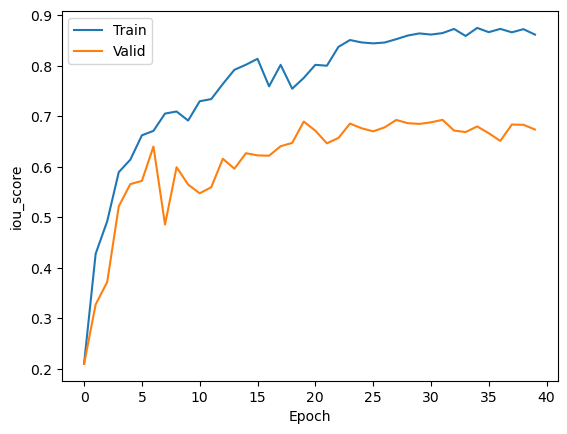

In [5]:
train(
    model,
    loss,
    metrics,
    goal_metric,
    goal_comparison,
    optimizer,
    DEVICE,
    verbose,
    n_epochs,
    train_loader,
    valid_loader,
    lr_schedule
)

It is now time to test the best model.

In [8]:
best_model = torch.load('./best_model.pth')

test_dataset = CustomDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=validation_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn)
)

test_loader = DataLoader(test_dataset)

test_epoch = utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 92/92 [00:18<00:00,  5.04it/s, dice_loss - 0.2561, iou_score - 0.6716]


Lets visualize how the model performs during inference. 

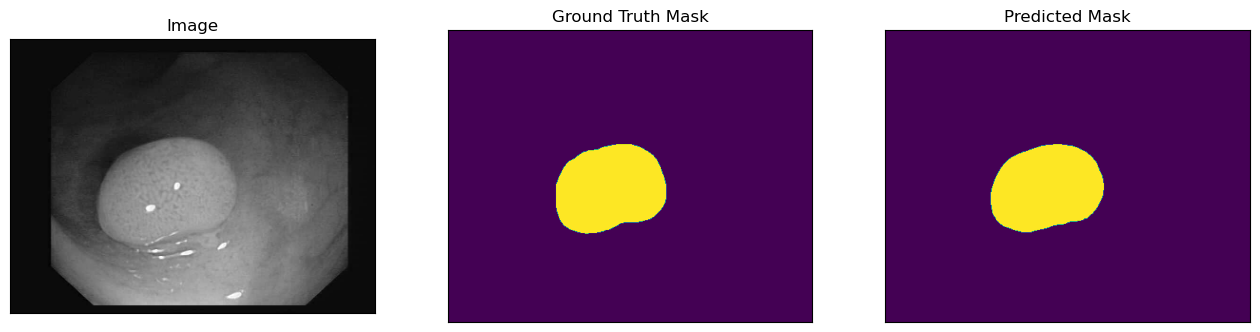

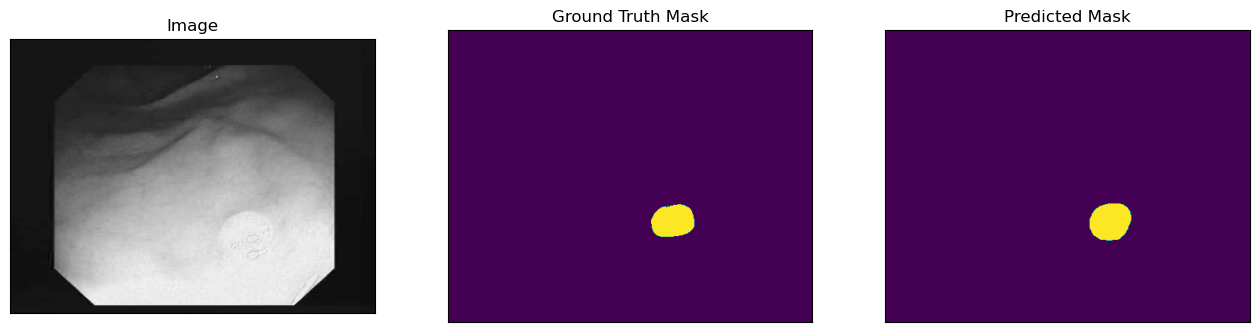

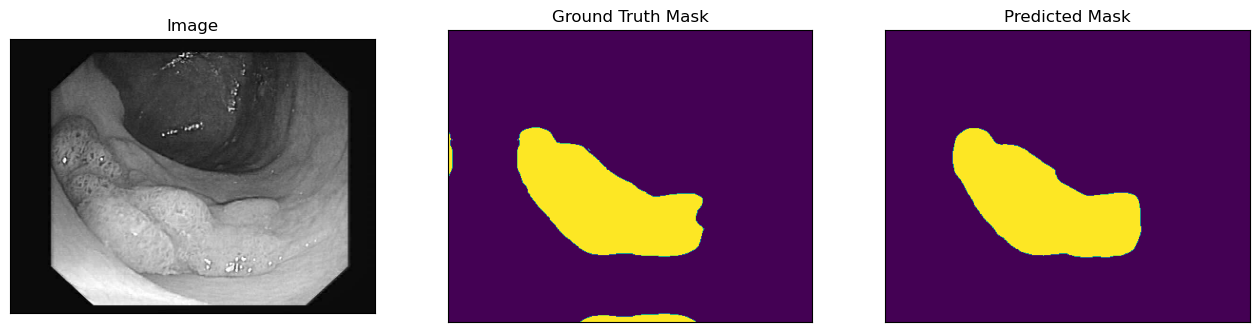

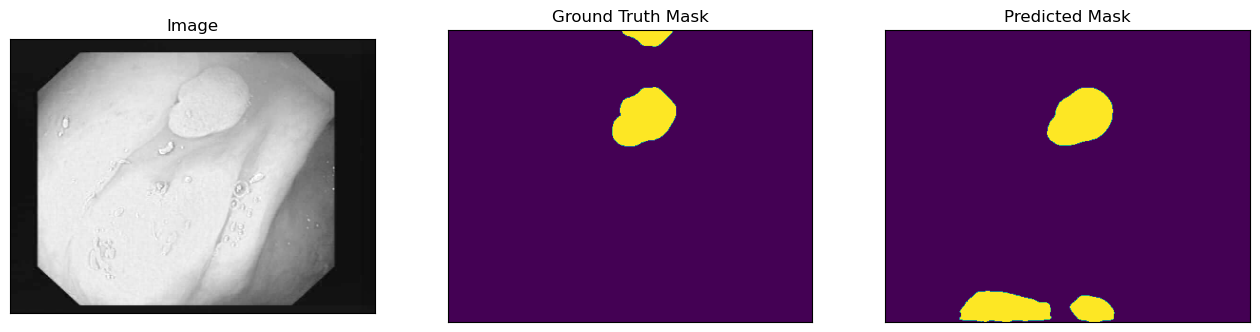

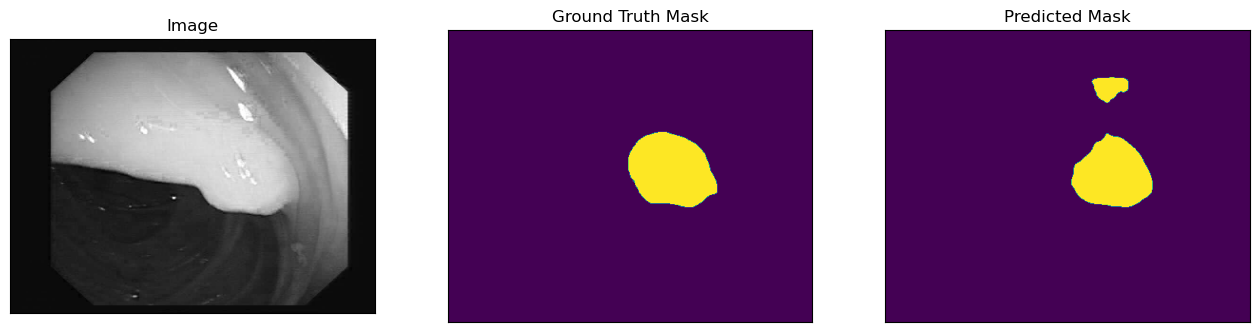

In [11]:
test_dataset_vis = CustomDataset(x_test_dir, y_test_dir)

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )